## Introduction
---
- Machine Learning applications in the field of Medicine to support and help the diagnosis of various diseases is crucial, to catch these at an early state. For this the algorithms
used have to take into account the most telling characteristics about the tests performed to analyze the targeted anatomical part of the patient. This is true in the particular case of Brain Tumors where there are typical exams that are prescribged in order to find if there is a tumor in the cerebral cortex of the patient.
- With the intent to build a model that classifies the imagiological results of tests like CT scans and MRIs into 'healty' or 'cancer' classes, to support the specialists decisions, we decided to train said model with a dataset with about 4600 unique samples of these types of exams, consisting their image results. 
-Given time we will explore the classification between different types of cancer in the brain cancer category.
---
## Step 1 - Data Exploration and Preprocessing

- Inspecting the dataset structure and labels:  
  - here is where we can separate the dataset through the labels Cancer/Healthy;
  - given the separation we may start to operate in the dataset

- The 1st operation needed is to reduce the images to a fixed shape, normalizing them into the same resolution;
- Next we also need to split the dataset as said in the project proposal, in "Training Data" and "Testing Data";
---
#### Process
- For this step then we will use "pandas" library to read the CSV metadata in order to get the information provided about the images
- When this is completed we will separate the data into "Healthy" and "Cancer" lists
- After this the main preprocessing of the data will begin 

In [9]:
import numpy as np
import pandas as pd
\
DEBUG = True

csv_file = "./data/metadata.csv"

"""This method reads the data from a CSV file
returning said data."""
def read_data(csv_file):
    df = pd.read_csv(csv_file)
    return df 

data = read_data(csv_file)

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(data)
    

🔴--------------🔴   Debug   🔴--------------🔴

      Unnamed: 0                  image   class format mode          shape
0              0         Cancer (1).jpg   tumor   JPEG  RGB  (512, 512, 3)
1              1         Cancer (1).png   tumor    PNG    L     (300, 240)
2              2         Cancer (1).tif   tumor   TIFF  RGB  (256, 256, 3)
3              3        Cancer (10).jpg   tumor   JPEG  RGB  (512, 512, 3)
4              4        Cancer (10).tif   tumor   TIFF  RGB  (256, 256, 3)
...          ...                    ...     ...    ...  ...            ...
4595        4595  Not Cancer  (995).jpg  normal   JPEG  RGB  (168, 300, 3)
4596        4596  Not Cancer  (996).jpg  normal   JPEG  RGB  (509, 452, 3)
4597        4597  Not Cancer  (997).jpg  normal   JPEG  RGB  (197, 177, 3)
4598        4598  Not Cancer  (998).jpg  normal   JPEG  RGB  (217, 232, 3)
4599        4599  Not Cancer  (999).jpg  normal   JPEG  RGB  (221, 228, 3)

[4600 rows x 6 columns]


#### Part 1 - Completed
---
- For now we have a variable `data` that has all the information in the file metadata stored in an N column matrix. Since this is the case we can pick and choose the data that we need to separate in the different classes. 

In [10]:
def get_list(data, column):
    list = data[column] # get the info on column class
    return list 

# Get the image labels
labels = get_list(data, column="class")

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(labels, sep="\n")

# Get the images list
images = get_list(data, column="image")

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(images)

# Split the images into healty/cancer
cancer  = images[labels=="tumor"]
healthy = images[labels=="normal"]

print(cancer, healthy, sep="\n\n")

🔴--------------🔴   Debug   🔴--------------🔴

0        tumor
1        tumor
2        tumor
3        tumor
4        tumor
         ...  
4595    normal
4596    normal
4597    normal
4598    normal
4599    normal
Name: class, Length: 4600, dtype: object
🔴--------------🔴   Debug   🔴--------------🔴

0              Cancer (1).jpg
1              Cancer (1).png
2              Cancer (1).tif
3             Cancer (10).jpg
4             Cancer (10).tif
                ...          
4595    Not Cancer  (995).jpg
4596    Not Cancer  (996).jpg
4597    Not Cancer  (997).jpg
4598    Not Cancer  (998).jpg
4599    Not Cancer  (999).jpg
Name: image, Length: 4600, dtype: object
0         Cancer (1).jpg
1         Cancer (1).png
2         Cancer (1).tif
3        Cancer (10).jpg
4        Cancer (10).tif
              ...       
2508    Cancer (995).jpg
2509    Cancer (996).jpg
2510    Cancer (997).jpg
2511    Cancer (998).JPG
2512    Cancer (999).jpg
Name: image, Length: 2513, dtype: object

2513     Not Can

#### Part 2 - Completed
---
- Separation of the images into the binary classes predetermined: `cancer` & `healthy` 
- With this we have the possibility of determining the priors for example
- We should also split the dataset in `training` and `testing data` @ this point

🔴--------------🔴   Debug   🔴--------------🔴



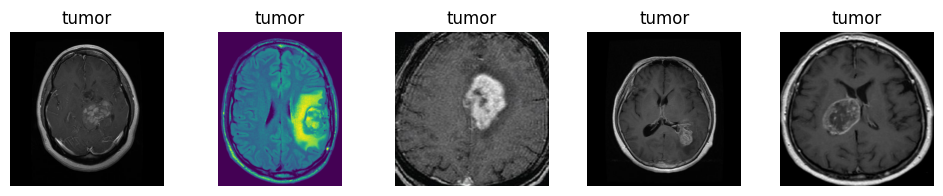

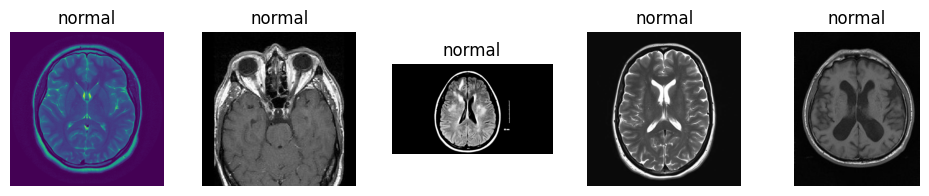

Number of cancer images: 2513
Number of healthy images: 2087


In [11]:
import matplotlib.pyplot as plt
from PIL import Image
import random as rand
import os

cancer_img_dir= "./data/cancer"
healthy_img_dir = "./data/healthy"

N = 5

def random_plot(image_list, label, image_dir, n=N):
    plt.figure(figsize=(12,2))
    for i, img_name in enumerate(image_list[:n]):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(label)
    plt.show()

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    random_plot(cancer.to_list(), "tumor", cancer_img_dir)
    random_plot(healthy.to_list(), "normal", healthy_img_dir)
    print(f"Number of cancer images: {len(cancer)}")
    print(f"Number of healthy images: {len(healthy)}")

#### Part 3 - Image Preprocessing/Normalization and Reshape
---
- Since the images have different resolutions and formats they should be normalized to the same size in order to build a solid foundation of comparison to train the model.
- To deal with that processing we decided to resize all images to a 256x256 resolution, although that number can be changed.
    - All 'L' format images shall be converted to 'RGB'.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9921259842519685].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0078740157480315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0078740157480315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0078740157480315].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0078740157480315].


Number of healthy images processed: 2087
Number of cancer images processed: 2513
🔴--------------🔴   Debug   🔴--------------🔴


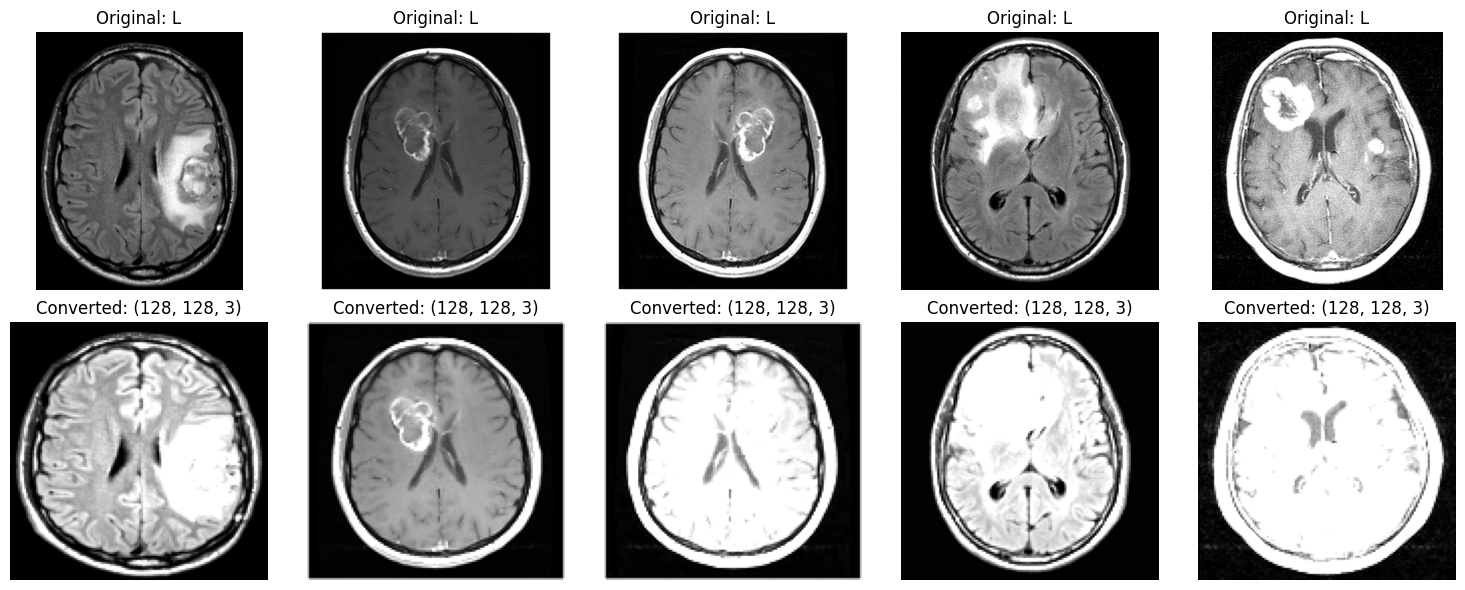

In [ ]:
def preprocess_img(img_path,target_size=(128,128)):    
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0

    return img_array

def preprocess_all_img(img_dir):

    all_array   = []
    image_files = os.listdir(img_dir) # Used to create a list of all file's paths of said directory

    for img_file in image_files:
        img_path  = os.path.join(img_dir,img_file)
        img_array = preprocess_img(img_path)
        all_array.append(img_array)
    
    return all_array

healthy_img_array = np.array(preprocess_all_img(healthy_img_dir))
cancer_img_array  = np.array(preprocess_all_img(cancer_img_dir))

# Check the results
print(f"Number of healthy images processed: {len(healthy_img_array)}")
print(f"Number of cancer images processed: {len(cancer_img_array)}")


if DEBUG == True : # It allows to individually check 10 different images for either healthy or cancer
    
    print("🔴--------------🔴   Debug   🔴--------------🔴")
    def check_grayscale_conversion(grayscale_image_paths, num_samples=5):
        fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
        
        for i, img_filename in enumerate(grayscale_image_paths[:num_samples]):
            img_path = os.path.join(cancer_img_dir, img_filename)
            
            # Pre conversion
            original = Image.open(img_path)
            axes[0, i].imshow(original, cmap='gray')
            axes[0, i].set_title(f'Original: {original.mode}')
            axes[0, i].axis('off')
            
            # Post conversion
            converted = preprocess_img(img_path)
            axes[1, i].imshow(converted)
            axes[1, i].set_title(f'Converted: {converted.shape}')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()

    # Get grayscale filenames from metadata
    grayscale_filenames = [row['image'] for _, row in data[data['mode'] == 'L'].iterrows()]

    # Now run with the fixed function
    check_grayscale_conversion(grayscale_filenames)

#### Part 4 - Split the data into Training/Testing
---
- This will be split in an 80/20 where both classes have to be reasonably represented in the samples, especially in the training data
- First we will use the train_test_split method to split the data, after the data has been combined as a single list with labels and images 
- Note: 
  - in the train_test_split function the value 42 choosen for `random_state` is choosen as it is a standard value, choosen to ensure reproduceability, meaning that it ensures that the data split is always the same every time the code is run, however it is just a random value and any can be used as long as it is maintained the same throughout multiple runs of the code.   


In [13]:
from sklearn.model_selection import train_test_split

# Splitting the data in testing and training data samples
all_images = np.concatenate([healthy_img_array, cancer_img_array], axis=0)
all_labels = ['tumor'] * len(cancer) + ['normal'] * len(healthy)

X_train, X_test, Y_train, Y_test = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42
)

# Converting the returned lists into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

X_test  = np.array(X_test)
Y_test  = np.array(Y_test)

if DEBUG == True:
    print(f"🔴--------------🔴   Debug   🔴--------------🔴\n")
    print(f"Training DataSet size = {len(X_train)}, TestSize = {len(X_test)}" )
    print(Y_train, sep="\n")
    print(Y_test, sep="\n")

🔴--------------🔴   Debug   🔴--------------🔴

Training DataSet size = 3680, TestSize = 920
['tumor' 'tumor' 'normal' ... 'tumor' 'normal' 'tumor']
['normal' 'normal' 'tumor' 'normal' 'tumor' 'normal' 'tumor' 'tumor'
 'normal' 'normal' 'normal' 'tumor' 'tumor' 'tumor' 'normal' 'tumor'
 'tumor' 'normal' 'normal' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'normal' 'normal' 'tumor' 'normal' 'normal' 'normal' 'tumor' 'tumor'
 'tumor' 'tumor' 'normal' 'normal' 'tumor' 'tumor' 'normal' 'normal'
 'tumor' 'normal' 'normal' 'tumor' 'tumor' 'normal' 'tumor' 'tumor'
 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor' 'normal' 'normal' 'tumor'
 'tumor' 'tumor' 'tumor' 'normal' 'tumor' 'tumor' 'tumor' 'tumor' 'tumor'
 'normal' 'tumor' 'normal' 'normal' 'normal' 'normal' 'normal' 'tumor'
 'tumor' 'normal' 'tumor' 'tumor' 'normal' 'tumor' 'normal' 'normal'
 'tumor' 'normal' 'tumor' 'normal' 'normal' 'tumor' 'tumor' 'normal'
 'tumor' 'tumor' 'normal' 'tumor' 'normal' 'tumor' 'tumor' 'tumor' 'tumor'
 'tumor' 

#### Part 5 - Choosing the Model 
---
- As the chosen model totally reflects the results of our program, we decided to stick to CNN (Convolutional Neural Network) that is pretty reliable when it comes to analyzing image, video and music data.
- Source of inspiration : https://www.kaggle.com/code/kanncaa1/convolutional-neural-network-cnn-tutorial

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models              import Sequential
from tensorflow.keras.layers              import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

MANUAL = True

# CNN
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_train[0].shape),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'), 
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

if MANUAL == True:
    # Since model.fit() requires numeric labels
    Y_train_numeric = np.array([1 if label == 'tumor' else 0 for label in Y_train])
    Y_test_numeric  = np.array([1 if label == 'tumor' else 0 for label in Y_test])
else : # Automatic labeling
    label_encoder   = LabelEncoder()
    Y_train_numeric = label_encoder.fit_transform(Y_train)
    Y_test_numeric  = label_encoder.transform(Y_test)

# Start without augmentation to get baseline
history = model.fit(
    X_train, Y_train_numeric,
    batch_size=8,
    epochs=30,
    validation_data=(X_test, Y_test_numeric),
    verbose=1
)


/home/joao/Documents/feup/masters/1st/1sem/apc/ml-mainproject/project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 55ms/step - accuracy: 0.6500 - loss: 0.6090 - precision: 0.6886 - recall: 0.6557 - val_accuracy: 0.7522 - val_loss: 0.5097 - val_precision: 0.7847 - val_recall: 0.7535
Epoch 2/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.7465 - loss: 0.5056 - precision: 0.8115 - recall: 0.6980 - val_accuracy: 0.7815 - val_loss: 0.4651 - val_precision: 0.8268 - val_recall: 0.7594
Epoch 3/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.7921 - loss: 0.4479 - precision: 0.8511 - recall: 0.7507 - val_accuracy: 0.8163 - val_loss: 0.4064 - val_precision: 0.8479 - val_recall: 0.8091
Epoch 4/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 27s 58ms/step - accuracy: 0.8351 - loss: 0.3860 - precision: 0.8921 - recall: 0.7940 - val_accuracy: 0.8446 - val_loss: 0.3761 - val_precision: 0.9265 - val_recall: 0.7773
Epoch 5/30
460/460 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.8690 - loss: 0.3281 - precision: 0.9273 - recall: 0.8249 - val_accuracy: 0.8196 - va

KeyboardInterrupt: 